# High resoltion methods lab 
## TSIA 202b
*Adrien Boitreaud*

In [257]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.linalg import hankel
from scipy import linalg

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [258]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [259]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [260]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [261]:
IPython.display.Audio('ClocheB.WAV')

In [262]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

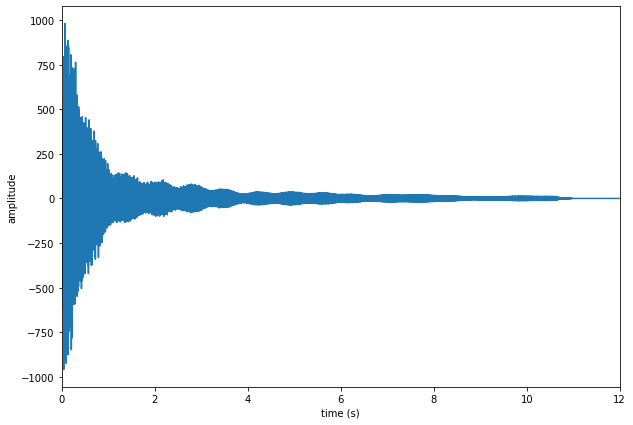

In [263]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [264]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# Synthetic signal

In [265]:
N = 63
delta = np.array([0, -0.05])
f = np.array([1/4, 1/4+1/N])
a = np.array([1, 10])
phi = np.random.uniform(-np.pi, np.pi, size = 2)
x = Synthesis(N,delta,f,a,phi)

## 3.1 Spectral analysis by Fourier transform

In [266]:
per = np.abs(np.fft.fft(x, n = N))
per = np.roll(per, len(per)//2)
nu = np.linspace(-0.5, 0.5, N)

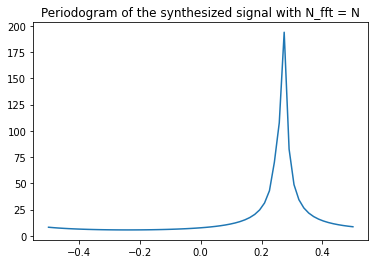

In [267]:
plt.plot(nu, per)
plt.title('Periodogram of the synthesized signal with N_fft = N')
plt.show()

In [268]:
per = np.abs(np.fft.fft(x, n = 1024))
per = np.roll(per, len(per)//2)
nu = np.linspace(-0.5, 0.5, 1024)

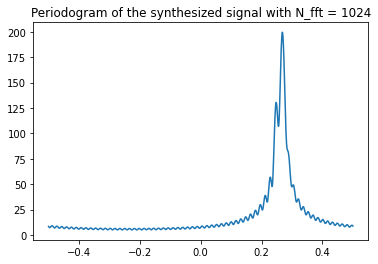

In [269]:
plt.plot(nu, per)
plt.title('Periodogram of the synthesized signal with N_fft = 1024')
plt.show()

For $N_{fft} = N$, the spectral resolution is too low to separate the two frequencies. However for $N_{fft}=1024$, we can see a small peak before the large one, which seems to reprensent the first frequency $f_0$.

## 3.2 High resolution methods
### 3.2.1 ESPRIT method

In [270]:
def ESPRIT(x, n, K):
    N =len(x)
    l = N - n + 1
    c = x[:n]
    r = x[n-1:]
    X = hankel(c, r)
    Rxx = X @ (X.conj().T)/l #empirical covariance matrix
    U1, Lambda, U2 = linalg.svd(Rxx)
    W = U1[:,:K]
    Wup = W[1:,:] # remove first row
    Wdown = W[:-1,:] # remove last row
    Phi = np.linalg.pinv(Wdown)@Wup
    eig_val, _ = np.linalg.eig(Phi)
    delta_est = np.log(np.abs(eig_val))
    f_est = np.angle(eig_val)/(2*np.pi)
    return delta_est, f_est

In [271]:
#estimation of the amplitude and phases
def LeastSquares(x, delta, f):
    K = len(f)
    #let's build the Vandermonde matrix first
    t = np.arange(N).reshape(-1,1) #column vector 
    row_vect = np.array([1j*2*np.pi*fk for fk in f]) + np.array(delta)
    row_vect = row_vect.reshape(1,K) #row vector
    Vandermonde = np.exp(t@row_vect) #Vandermonde is product of the two above vectors
    alpha = np.linalg.pinv(Vandermonde)@x
    a_est = np.abs(alpha)
    phi_est = np.angle(alpha)
    return a_est, phi_est

#### Application to synthesized signal

In [272]:
delta_est, f_est = ESPRIT(x, 32, 2)

In [273]:
print(f'The estimated damping factors are {delta_est}')

The estimated damping factors are [-5.00000000e-02 -5.55111512e-16]


In [274]:
print(f'The estimated frequencies are {sorted(f_est)}')
print(f'The initial frequencies we had chosen were {list(f)}')

The estimated frequencies are [0.24999999999999997, 0.2658730158730159]
The initial frequencies we had chosen were [0.25, 0.26587301587301587]


The results we obtained are very good, the frequencies are found, as well as the damping factors.

In [275]:
a_est, phi_est = LeastSquares(x, delta_est, f_est)

In [276]:
print(f'The amplitudes we have estimated are {sorted(a_est)}')

The amplitudes we have estimated are [1.0000000000000175, 9.99999999999997]


In [277]:
print(f'The estimated phases are {phi_est}, while the drawn ones at the beginning were {sorted(phi)}')

The estimated phases are [2.64760074 2.47005973], while the drawn ones at the beginning were [2.470059726829958, 2.647600744034545]


Here again, the results of the estimation are exactly equal to the initial parameters, as we may want to keep only two or three relevant decimals.

### 3.2.2 MUSIC method
#### Music pseudo-spectrum

In [278]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [279]:
def MUSIC(x, n, K):
    delta = np.arange(-0.1, 0.1, 0.005)
    f = np.arange(0.22, 0.3, 0.0001)
    X, Y = np.meshgrid(delta, f)
    Z = X + 1j*np.pi*2*Y
    # Make data
    c = x[:n]
    r = x[n-1:]
    X = hankel(c, r)
    l = N - n + 1
    Rxx = X @ (X.conj().T)/l #empirical covariance matrix
    U1, _, _ = linalg.svd(Rxx)
    W_orth = U1[:,K:]
    t = np.arange(n)
    v = np.array([np.exp(elem*(Z)) for elem in t])
    P = np.zeros(Z.shape)
    for i in range(len(f)):
        for j in range(len(delta)):    
            norm = np.linalg.norm(W_orth.conj().T@v[:,i,j])**2
            P[i,j] = np.log(1/norm)
    X, Y = np.meshgrid(delta, f)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, P, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.show()

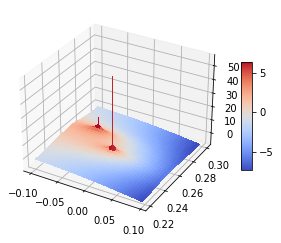

In [280]:
MUSIC(x, 32, 2)

The two peaks we can see on this plot are the two poles at coordinates (-0.05, 0.266) and (0, 0.25) for the tuples (amping factorn frequency). This shows that MUSIC is gives a good estimation of the frequencies and the damping factors contituing a new unknown sound.

## 4 Audio signals
### 4.1 Spectral analysis by Fourier transform

In [185]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
x = np.array(data[0])

In [186]:
per = np.abs(np.fft.fft(x, n = 2048))
per = np.roll(per, len(per)//2)
nu = np.linspace(0, sampling_frequency, len(per))

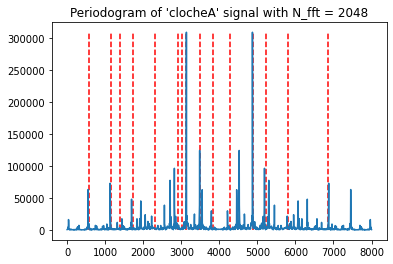

In [187]:
plt.plot(nu, per)
plt.title('Periodogram of \'clocheA\' signal with N_fft = 2048')
vlines = [0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2, 4.5, 5, 5.9]
plt.vlines([line*1160 for line in vlines],
           0, max(per), colors='red', linestyles='dashed')
plt.show()

### 4.2 High resolution method

In [249]:
K, n = 54, 512
l = 2*n
N = n + l - 1
extract = x[10000:10000+N]

In [252]:
def est_syntesize(extract, n=n, K=K):
    delta_est, f_est = ESPRIT(extract, n, K)
    a_est, phi_est = LeastSquares(extract, delta_est, f_est)
    synth = np.real(Synthesis(8*N, delta_est, f_est, a_est, phi_est)) # Imaginary parts are very close to zero, we discard them
    write('synth_bell.wav', sampling_frequency, np.array(synth.reshape(len(synth)), dtype=np.int16)) # to write a new wave file

In [253]:
est_syntesize(extract)

In [255]:
IPython.display.Audio('synth_bell.WAV')

In [256]:
extract_6 = x[6000:6000+N]
est_syntesize(extract_6)
IPython.display.Audio('synth_bell.WAV')

I have tried to estimate the parameters and re synthesize the sound with these parameters from two different extracts of the bell sound, each one of length N. If we take the sound from the 10000th sample, we clearly hear the resonance by the signal quickly becomes like a hissing, which may mean that I have an issue in the estimation of a certain damping factor, associated with the frequency that we hear at the end of the recording.

For an extract taken from the 6000th sample, we hear the end of the bell and then the resonance sound very well. There is still the same probrem of the hissing at the end of the sound recording.

This problem may actually come from the fact that I have taken a window that is too big compared to the initial window. While the initial window was of size N, the synthesized sound has length 8N. If we cut the synthesized sound before, making it of length 5N for example, we delete the part were we hear the hissing
Without this problem of hissing, this high resolution method provides a good estimation of the parameters, as the sound we then synthsized is exactly the same as the real one. The computations are very fast compared to what we did in the previous lab.